In [42]:
%load_ext autoreload 
%autoreload 2

In [15]:
%matplotlib inline

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from regression import OLS
x = np.array([1, 2, 3])
y = np.array([4, 5, 6])
z = np.array([1, 2, 1])

# test polynomial fit for simple data
franke_sampled = OLS(x, y, z, 1)
franke_sampled.var_beta

array([8.22794963e-29, 6.81994701e-28, 2.03245775e-30, 1.27203821e-29])

## Plot Franke Function with noise

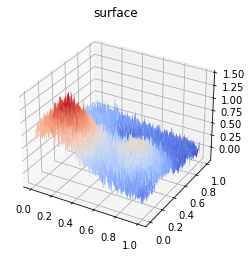

In [37]:
from franke_function import FrankeFunction as Fr
from matplotlib import cm

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], y.shape[1])

z = Fr(x, y) + noise*0.1

ax = plt.subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap=cm.coolwarm)
ax.set_title('surface');

## Comparing b_0 with subtracted mean 

In [21]:
from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.preprocessing import StandardScaler

polynomial_deg = 2

x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.01

sol = OLS(x.ravel(), y.ravel(), z.ravel(), polynomial_deg)
print("Beta with no scaling: ", sol.beta_OLS)

x_cen = (x - np.mean(x))/np.std(x)
y_cen = (y - np.mean(y))/np.std(y)
sol = OLS(x_cen.ravel(), y_cen.ravel(), z.ravel(), polynomial_deg)
print("Beta with standardized x and y: ", sol.beta_OLS)


z_cen = (z - np.mean(z))/np.std(z)
sol_cen = OLS(x_cen.ravel(), y_cen.ravel(), z_cen.ravel(), polynomial_deg)
print("Beta with standardized x, y and z: ", sol_cen.beta_OLS)

scaler = StandardScaler() 

x_cen = scaler.fit_transform(x.reshape(-1, 1))
y_cen = scaler.fit_transform(y.reshape(-1, 1))
z_cen = scaler.fit_transform(z.reshape(-1, 1))

sol_cen = OLS(x_cen.ravel(), y_cen.ravel(), z_cen.ravel(), polynomial_deg)
print("Comparing with SK-Learn: ", sol_cen.beta_OLS)
# Interesting notes: 
# for a polynomial of degree 1 subtracting the mean causes beta[0] to approach zero. 

Beta with no scaling:  [[ 1.26751255]
 [-1.11746422]
 [-0.07318367]
 [-1.43735023]
 [ 2.05320843]
 [ 0.29974906]
 [ 0.38081322]
 [-1.55467929]
 [ 0.09051496]]
Beta with standardized x and y:  [[ 0.42910572]
 [-0.10986705]
 [ 0.0082932 ]
 [-0.20507958]
 [ 0.07421438]
 [ 0.0094165 ]
 [-0.03122052]
 [-0.03532815]
 [ 0.0006311 ]]
Beta with standardized x, y and z:  [[ 0.07755904]
 [-0.38218063]
 [ 0.02884852]
 [-0.7133844 ]
 [ 0.25816017]
 [ 0.03275599]
 [-0.10860287]
 [-0.12289155]
 [ 0.00219531]]
Comparing with SK-Learn:  [[ 0.07755904]
 [-0.38218063]
 [ 0.02884852]
 [-0.7133844 ]
 [ 0.25816017]
 [ 0.03275599]
 [-0.10860287]
 [-0.12289155]
 [ 0.00219531]]


# Predicting Frankes function

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x = np.linspace(0, 1, 500)
y = np.linspace(0, 1, 500)
x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], x.shape[1])
#z_real = Fr(x, y)
z = Fr(x, y) + + noise*0.18
    
scaler = StandardScaler() 
x_cent = scaler.fit_transform(x.reshape(-1, 1))
y_cent = scaler.fit_transform(y.reshape(-1, 1))
z_cent = scaler.fit_transform(z.reshape(-1, 1))

xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]), z_cent)
    
MSE = []
variance_beta = []
betas = []
R2s = []
for poly_deg in range(1, 6):
    print("Polynomial order: " + str(poly_deg))
    model = OLS(xy_cent_train[:, 0].ravel(), xy_cent_train[:, 1].ravel(), z_cent_train.ravel(), poly_deg)
    
    z_prediction = model.predict(xy_cent_test[:, 0], xy_cent_test[:, 1])
    MSE.append(model.MSE(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test))
    variance_beta.append(model.var_beta(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test))
    betas.append(model.beta_OLS)
    R2s.append(model.R2(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test))
print("Finish! ")
        
# Observasjonar: Det virker som at polynomene mine treffer ganske bra på franke-funksjonen. 
# Med introduksjon av støy øker bias-variance tradeoff. 
# Kva skjer om eg ikkje sentrerer data? 

# Sentrerer fordi: Det er ikkje relevant om eg sjekker data i området [0, 1] eller [11, 12]. Sentrering gjer at data
# måles opp mot sin egen spredning, ikkje korvidt det ligg langt unna origio. Polynomer er sensitive for om data er 
# under eller over origo. 

# Skalerer fordi: Det er ikkje relevant om z-verdiane ligg i [0 100] eller [200 1000]. Ved å dele på standardavviket
# får vi data der 2 betyr to ganger større enn standardavviket. Det er mer intuitivt og gjer det lettere å forstå 
# data ved bare å å kaste et blikk på det. 

# Trur også det fører til at beta sentreres rundt 0! 

# R2: modellen min kan forklare ein høgare andel av data når eg auker graden til polynomet

# Øker treffsikkerheiten med meir data?? Jau, får meir trening til modellen og meir å samanlikne med. 
# Også i forelesning 17 september. 

Polynomial order: 1
Polynomial order: 2
Polynomial order: 3
Polynomial order: 4
Polynomial order: 5
Finish! 


In [9]:
print(R2s) # øker
print(MSE) # synker

[0.5655357780374362, 0.5817474856468918, 0.6629071356438376, 0.7029826173553397, 0.7080087256985099]
[0.43509170991909385, 0.4188565880656902, 0.33757972081504456, 0.2974463588895803, 0.2924129914389989]


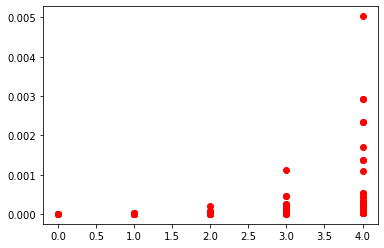

In [10]:
ax = plt.subplot(111)
for i in range(len(variance_beta)):
    for j in range(len(variance_beta[i])):
        ax.plot(i, variance_beta[i][j], 'ro')


In [11]:
%matplotlib inline

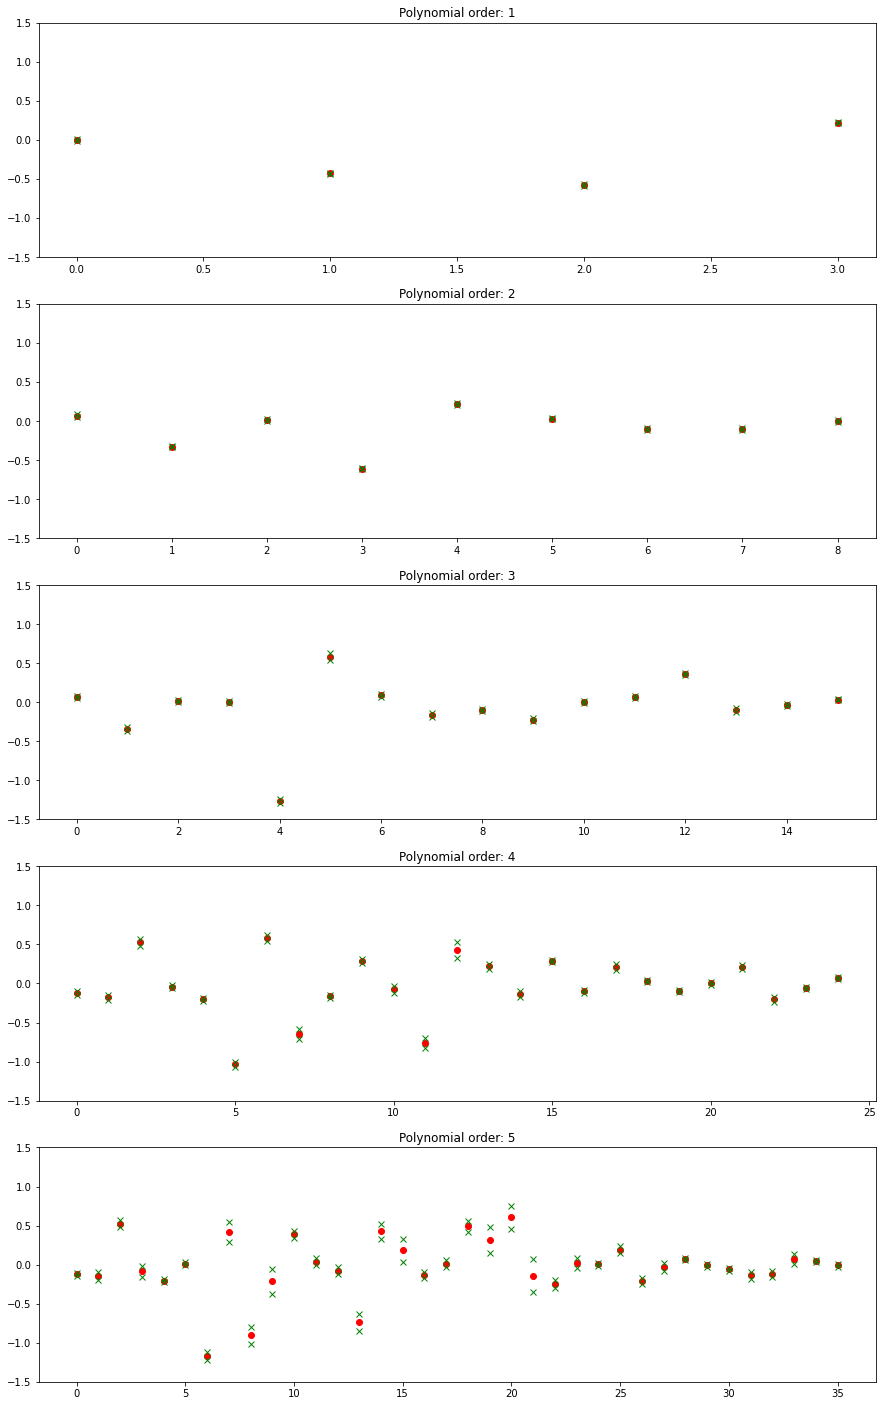

In [19]:
import matplotlib.pyplot as plt
n_polynom = len(MSE)

fig, axs = plt.subplots(n_polynom, 1, figsize=(15, 25), facecolor='w', edgecolor='k')
axs = axs.ravel()

sigma = 3
for polynom_nr in range(n_polynom):
    for beta_i in range(len(betas[polynom_nr])):
        axs[polynom_nr].plot(beta_i, betas[polynom_nr][beta_i], 'ro') #plot middle beta
        axs[polynom_nr].plot(beta_i, betas[polynom_nr][beta_i] + sigma*np.sqrt(variance_beta[polynom_nr][beta_i]), 'gx') 
        axs[polynom_nr].plot(beta_i, betas[polynom_nr][beta_i] - sigma*np.sqrt(variance_beta[polynom_nr][beta_i]), 'gx') 
    axs[polynom_nr].set_title('Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr].set_ylim([-1.5, 1.5])
    
# Kule funn:
# Vi antar (som rimelig er med normalfordelt støy...) at variansen til beta er normalfordelt. 
# Eg tolker dette som at ulike rader gir ulike estimat på beta. 
#
# Er ulike konfidensintervall relatert til den faktiske funksjonen me prøver å sjå på?
# At den endrer seg meir i y-retning enn i x-retning?

In [22]:
np.std(z_cent_test)

0.9962696431628525

In [38]:
# Uten sentrering av data!


Polynomial degree:  1
Polynomial degree:  2
Polynomial degree:  3
Polynomial degree:  4
Polynomial degree:  5
Polynomial degree:  6
Polynomial degree:  7
Polynomial degree:  8
Polynomial degree:  9
Polynomial degree:  10
Polynomial degree:  11
Polynomial degree:  12
Polynomial degree:  13
Polynomial degree:  14


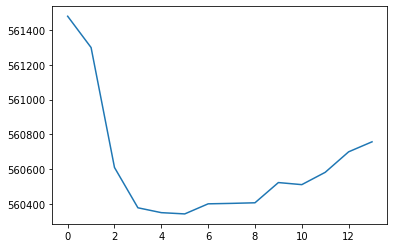

# Reasons for normalizing data

- We do not expect data to be much dependent on 